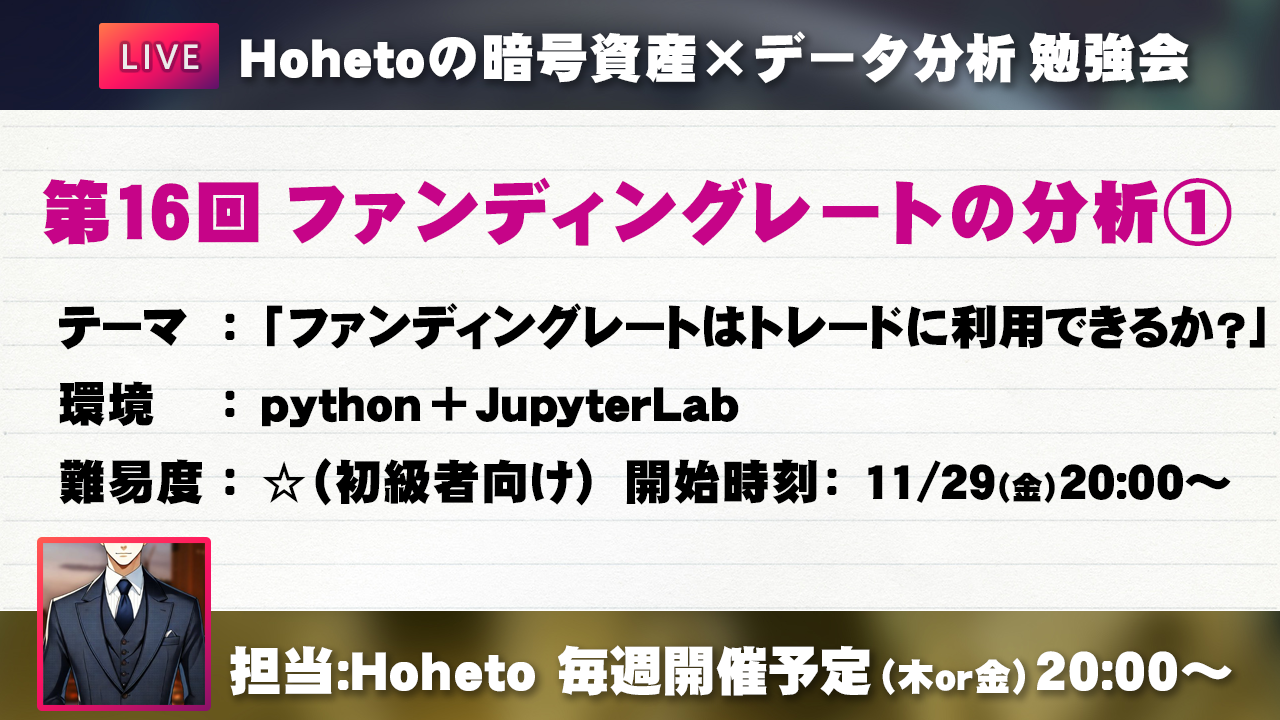

In [1]:
from IPython.display import Image

Image('./images/16_00.png')

# Hoheto勉強会 第16回 ファンディングレートの分析①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- ファンディングレートについて、その概要を解説します。
- ファンディングレートと値動きについて分析を行い、簡単な戦略を作成します。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆1つ。

# 環境設定

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [4]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# ファンディングレート（資金調達率）とは

- 暗号資産デリバティブ商品の一種である無期限先物契約に特有の仕組み。
  - 無期限先物契約の価格が現物価格から乖離しないように調整するための仕組みです。 
  - ロング（買い）ポジションとショート（売り）ポジションのバランスに応じて、一定の時間ごとに一方のポジション保有者から他方の保有者へ資金が支払われます。 
    - ファンディングレートが正の場合、ロングポジション保有者がショートポジション保有者に支払います。
    - ファンディングレートが負の場合、ショートポジション保有者がロングポジション保有者に支払います。 
  - 取引所によって異なりますが、一般的に無期限先物価格と現物価格の差（プレミアムインデックス）とドル短期金利を基に算出されます。 
  - 多くの取引所・多くの銘柄では、8時間ごとにファンディングレートの支払いが行われます。

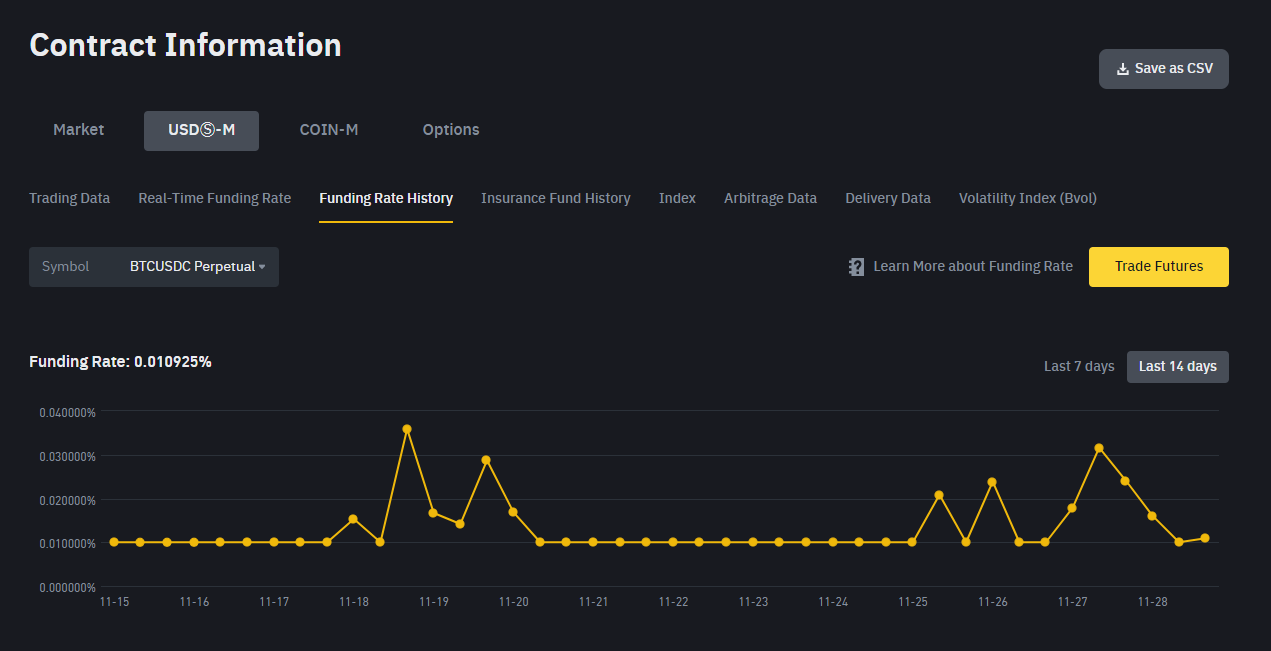

In [5]:
Image('./images/16_01.png', width=900)

- Binanceでは上記のように参照できます。
- また、過去のデータをCSVで一括取得できるようになっています。
- https://www.binance.com/en/futures/funding-history/perpetual/funding-fee-history

## ファンディングレートの計算式・徴収方法

- 計算方法
  - 無期限先物価格と現物価格の乖離が、プレミアムインデックスとして毎分計算されている。
  - このプレミアムインデックスの平均と米ドル金利を元に計算するのであるが、少々ややこしい。
  - プレミアムインデックス自体も、操作されにくいように、有効な買い板と売り板の厚みなどを利用して決められている。
  - プレミアムインデックスを1分足でAPIで取得可能なので、予測ファンディングレートの自炊は可能。

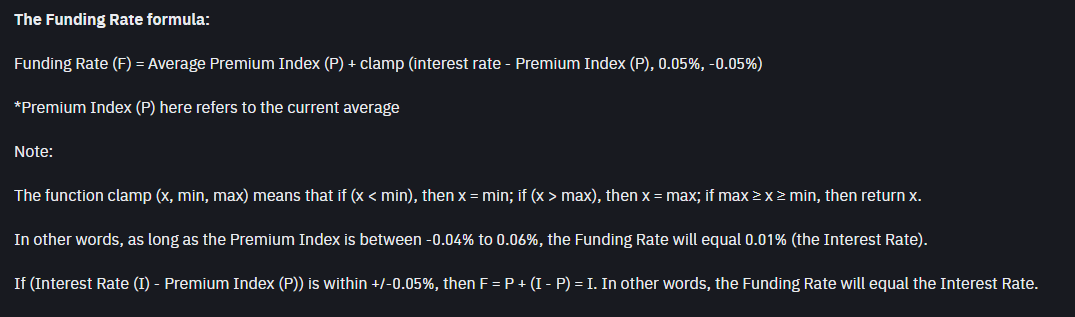

In [6]:
Image('./images/16_05.png', width=900)

- 結論として、プレミアムインデックスに対してファンディングレートは以下のようなグラフとなる。
  - 図は「BitMEXの無期限契約に課される資金調達率についての解説」 https://note.com/fcukoksan/n/n557c9478824c より引用。
  - BitMEXについての6年前の記事なので詳細は異なる可能性があるが、骨子は変わらない。

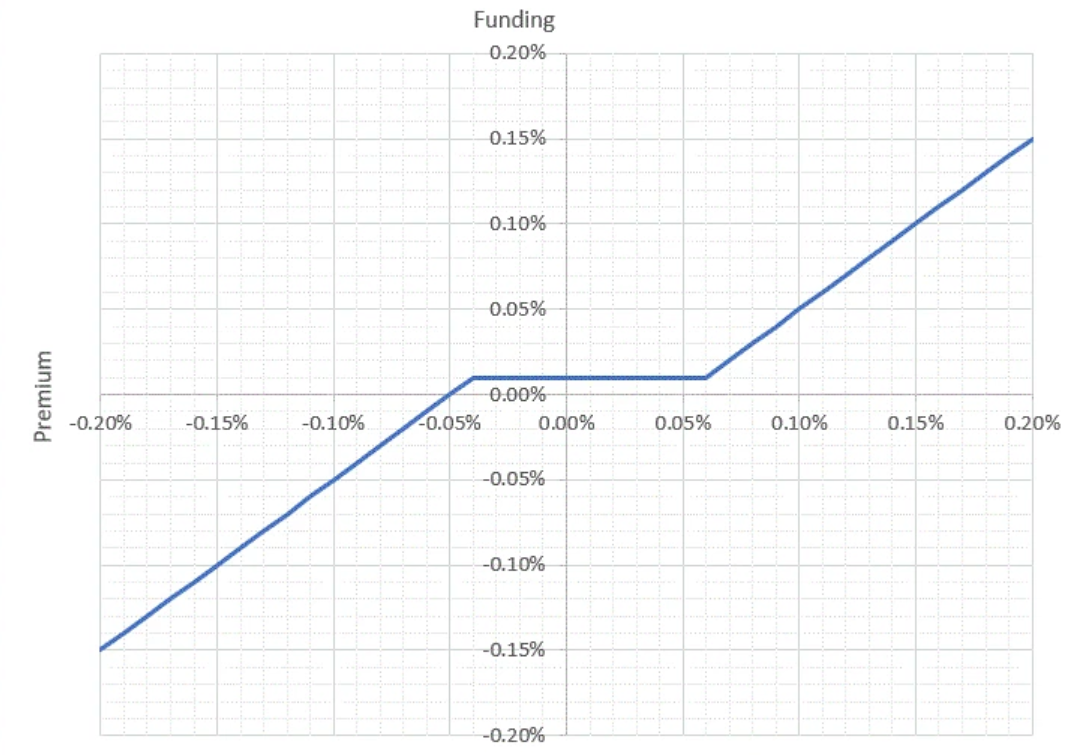

In [7]:
Image('./images/16_06.png', width=600)

- 参考
  - Funding Rateの解像度を上げる https://note.com/muzineco/n/n2e27c4b8c5fd
  - BitMEXの無期限契約に課される資金調達率についての解説 https://note.com/fcukoksan/n/n557c9478824c

- 徴収方法
  - ポジションサイズにファンディングレートをかけた金額が徴収される。
  - 8時間ごとのファンディングレートの場合、日本時間の9時・17時・深夜1時に徴収される。
  - 9:00～9:01の間に順次徴収されるため、跨いだと思っていても跨げていない場合があるので注意。

## ファンディングレートを利用した過熱状況の判断

- 無期限先物価格と現物価格の乖離が激しくなると、ファンディングレートが0.01%から乖離します。
- 過熱相場では、無期限先物価格が上乖離します。このため、ファンディングレートが高騰します。
- 閑散相場では、無期限先物価格が下乖離します。このため、ファンディングレートがマイナスになります。
- この状況を分かりやすく視覚化したものがファンディングレート（資金調達率）ヒートマップです。

- 下記は、直近1ヵ月のヒートマップです。Coinglassというサイトが有名です。
- https://www.coinglass.com/ja/FundingRateHeatMap

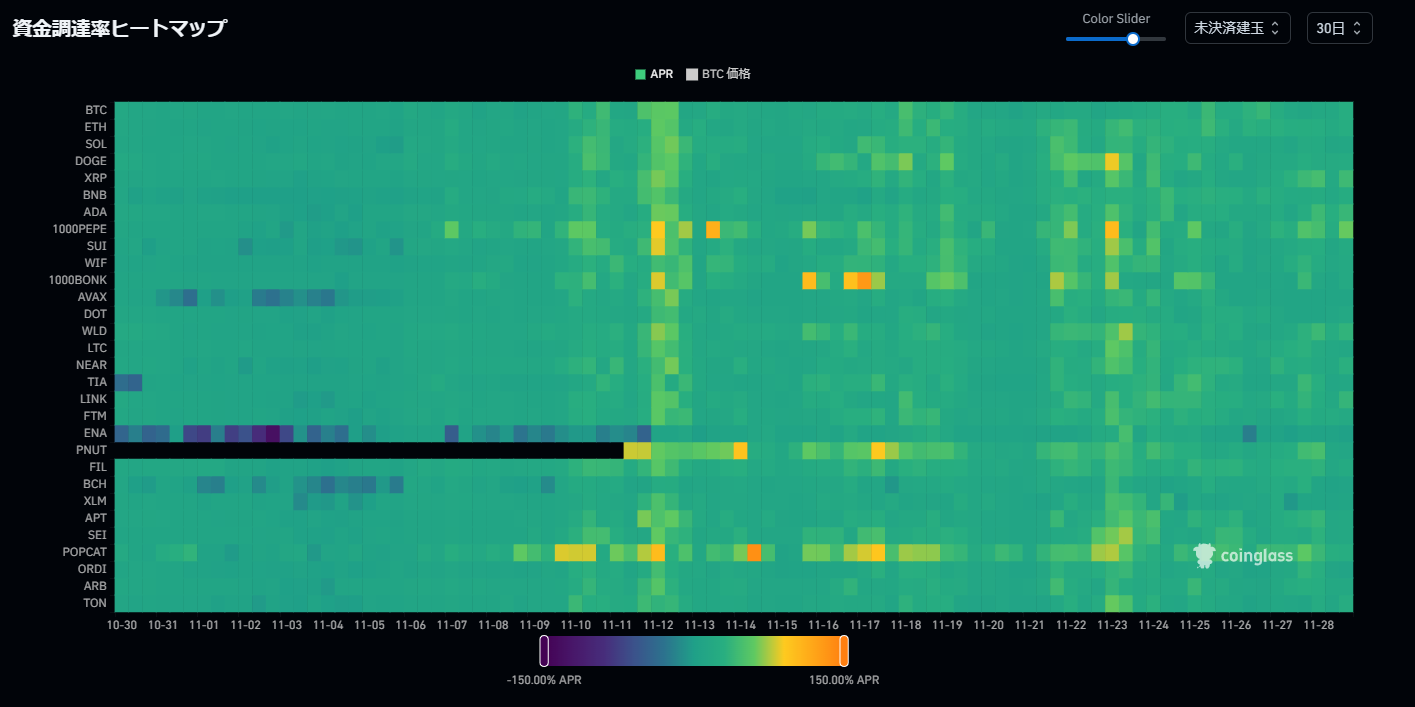

In [8]:
Image('./images/16_02.png', width=900)

- 今年2～3月の上昇相場では、アルトコインを中心にファンディングレートが高騰していました。
- 一方、今回の11月初旬からの上げ相場（トランプ大統領当選以降）ではそこまでの過熱は見られず、このため上昇余地がまだまだあると判断している人が多いです。

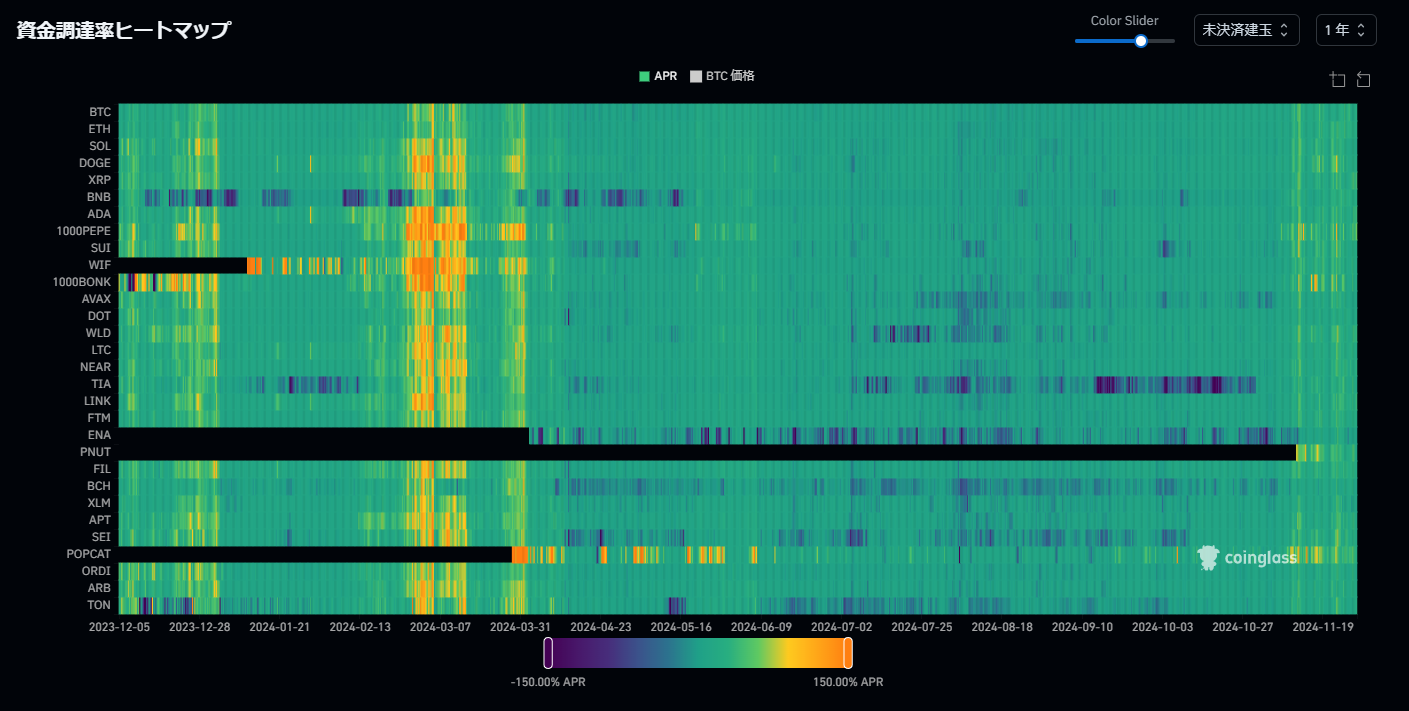

In [9]:
Image('./images/16_03.png', width=900)

- ファンディングレートを使った過熱状況の判断については、DEGさんのYouTube動画の切り抜きが分かりやすいです。
- https://www.youtube.com/watch?v=kX8XmU5MXIM

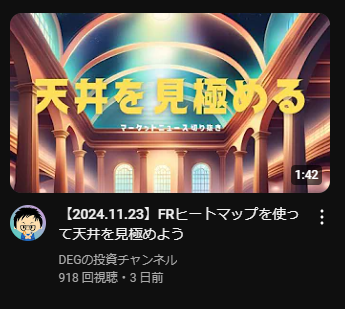

In [10]:
Image('./images/16_04.png', width=500)

# データ取得

## ビットコイン価格データ取得

- 期間は、Binanceでファンディングレートを取得可能になった2019年11月29日～2024年11月28日です。
- 使用データは、
  - Binanceビットコイン無期限先物 BTCUSDT PERP

In [11]:
apis = {
    'binance_perp': ccxt.binanceusdm(),
}

- ccxtを利用してOHLCVを取得する関数

In [12]:
from dateutil import parser

def fetch_ohlcv(exchange, symbol, from_date, to_date, timeframe):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    start_time = from_time
    limit = 1000
    ohlcv_list = []
    while True:
        if type(exchange) == str:
            api = apis[exchange]
        else:
            api = exchange
        ohlcv = api.fetch_ohlcv(symbol=symbol, timeframe=timeframe, since=start_time, limit=limit)
        if len(ohlcv) == 0:
            break
        ohlcv_list += ohlcv
        start_time = ohlcv[-1][0] + 1
        # print(f'{datetime.fromtimestamp(ohlcv[-1][0] / 1000)}')
        if start_time > to_time:
            break
        time.sleep(1)
    df = pd.DataFrame(ohlcv_list)
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df['ror'] = (df['close'] - df['open']) / df['open']
    df.columns = [f'{exchange}_{column}' for column in df.columns]
    return df

- 相関をプロットする関数

In [13]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

In [14]:
from_date = '2019-11-29'
to_date = '2024-11-28'

In [15]:
ohlcv = fetch_ohlcv('binance_perp', 'BTC/USDT:USDT', from_date, to_date, '8h')

In [16]:
ohlcv

,binance_perp_open,binance_perp_high,binance_perp_low,binance_perp_close,binance_perp_volume,binance_perp_ror
timestamp,,,,,,
2019-11-29 00:00:00+00:00,7417.00,7535.36,7394.57,7505.90,38757.465,0.011986
2019-11-29 08:00:00+00:00,7507.41,7810.60,7400.00,7803.96,102348.736,0.039501
2019-11-29 16:00:00+00:00,7804.95,7850.00,7660.00,7736.66,44712.985,-0.008750
2019-11-30 00:00:00+00:00,7737.23,7766.00,7713.67,7743.57,23442.272,0.000819
2019-11-30 08:00:00+00:00,7743.69,7800.00,7511.11,7536.00,68284.318,-0.026821
...,...,...,...,...,...,...
2024-11-28 16:00:00+00:00,95067.30,96082.70,94768.00,95694.40,38428.059,0.006596
2024-11-29 00:00:00+00:00,95694.40,96932.90,95404.50,95690.20,44183.363,-0.000044
2024-11-29 08:00:00+00:00,95690.20,98713.30,95690.10,98076.20,90596.336,0.024935


## Funding Rate取得

- 先ほど紹介したBinanceのサイトから、CSVでダウンロードして読み込ませます。
- https://www.binance.com/en/futures/funding-history/perpetual/funding-fee-history

In [17]:
fr = pd.read_csv('./data/16_Funding Rate History_BTCUSDT Perpetual_2024-11-28.csv')

In [18]:
fr

,Time,Contracts,Funding Interval,Funding Rate
0,2024-11-28 17:00:00,BTCUSDT Perpetual,8h,0.014326%
1,2024-11-28 09:00:00,BTCUSDT Perpetual,8h,0.010000%
2,2024-11-28 01:00:00,BTCUSDT Perpetual,8h,0.010000%
3,2024-11-27 17:00:00,BTCUSDT Perpetual,8h,0.016794%
4,2024-11-27 09:00:00,BTCUSDT Perpetual,8h,0.031205%
...,...,...,...,...
5714,2019-09-12 01:00:00,BTCUSDT Perpetual,8h,0.010000%
5715,2019-09-11 17:00:00,BTCUSDT Perpetual,8h,0.010000%
5716,2019-09-11 09:00:00,BTCUSDT Perpetual,8h,0.010000%
5717,2019-09-11 01:00:00,BTCUSDT Perpetual,8h,0.010000%


- インデックスに時刻を設定。
  - Timeカラムが日本時間になっているため、変換します。

In [19]:
import pytz
from dateutil import parser
from dateutil.tz import gettz

fr.index = fr['Time'].apply(lambda t: parser.parse(t).replace(tzinfo=gettz('Asia/Tokyo')).astimezone(pytz.UTC))

In [20]:
fr

,Time,Contracts,Funding Interval,Funding Rate
Time,,,,
2024-11-28 08:00:00+00:00,2024-11-28 17:00:00,BTCUSDT Perpetual,8h,0.014326%
2024-11-28 00:00:00+00:00,2024-11-28 09:00:00,BTCUSDT Perpetual,8h,0.010000%
2024-11-27 16:00:00+00:00,2024-11-28 01:00:00,BTCUSDT Perpetual,8h,0.010000%
2024-11-27 08:00:00+00:00,2024-11-27 17:00:00,BTCUSDT Perpetual,8h,0.016794%
2024-11-27 00:00:00+00:00,2024-11-27 09:00:00,BTCUSDT Perpetual,8h,0.031205%
...,...,...,...,...
2019-09-11 16:00:00+00:00,2019-09-12 01:00:00,BTCUSDT Perpetual,8h,0.010000%
2019-09-11 08:00:00+00:00,2019-09-11 17:00:00,BTCUSDT Perpetual,8h,0.010000%
2019-09-11 00:00:00+00:00,2019-09-11 09:00:00,BTCUSDT Perpetual,8h,0.010000%


- Funding Rateカラムが、「％」付きの文字列になっているため、変換して「fr」カラムに代入します。

In [21]:
fr['fr'] = fr['Funding Rate'].apply(lambda fr: float(fr.replace('%', '')) / 100)

In [22]:
fr

,Time,Contracts,Funding Interval,Funding Rate,fr
Time,,,,,
2024-11-28 08:00:00+00:00,2024-11-28 17:00:00,BTCUSDT Perpetual,8h,0.014326%,0.000143
2024-11-28 00:00:00+00:00,2024-11-28 09:00:00,BTCUSDT Perpetual,8h,0.010000%,0.000100
2024-11-27 16:00:00+00:00,2024-11-28 01:00:00,BTCUSDT Perpetual,8h,0.010000%,0.000100
2024-11-27 08:00:00+00:00,2024-11-27 17:00:00,BTCUSDT Perpetual,8h,0.016794%,0.000168
2024-11-27 00:00:00+00:00,2024-11-27 09:00:00,BTCUSDT Perpetual,8h,0.031205%,0.000312
...,...,...,...,...,...
2019-09-11 16:00:00+00:00,2019-09-12 01:00:00,BTCUSDT Perpetual,8h,0.010000%,0.000100
2019-09-11 08:00:00+00:00,2019-09-11 17:00:00,BTCUSDT Perpetual,8h,0.010000%,0.000100
2019-09-11 00:00:00+00:00,2019-09-11 09:00:00,BTCUSDT Perpetual,8h,0.010000%,0.000100


- 結合

In [23]:
ohlcv['fr'] = fr['fr']

In [24]:
ohlcv

,binance_perp_open,binance_perp_high,binance_perp_low,binance_perp_close,binance_perp_volume,binance_perp_ror,fr
timestamp,,,,,,,
2019-11-29 00:00:00+00:00,7417.00,7535.36,7394.57,7505.90,38757.465,0.011986,0.000100
2019-11-29 08:00:00+00:00,7507.41,7810.60,7400.00,7803.96,102348.736,0.039501,0.000100
2019-11-29 16:00:00+00:00,7804.95,7850.00,7660.00,7736.66,44712.985,-0.008750,0.000100
2019-11-30 00:00:00+00:00,7737.23,7766.00,7713.67,7743.57,23442.272,0.000819,0.000100
2019-11-30 08:00:00+00:00,7743.69,7800.00,7511.11,7536.00,68284.318,-0.026821,-0.000019
...,...,...,...,...,...,...,...
2024-11-28 16:00:00+00:00,95067.30,96082.70,94768.00,95694.40,38428.059,0.006596,NaN
2024-11-29 00:00:00+00:00,95694.40,96932.90,95404.50,95690.20,44183.363,-0.000044,NaN
2024-11-29 08:00:00+00:00,95690.20,98713.30,95690.10,98076.20,90596.336,0.024935,NaN


# 分析

## まずはプロット

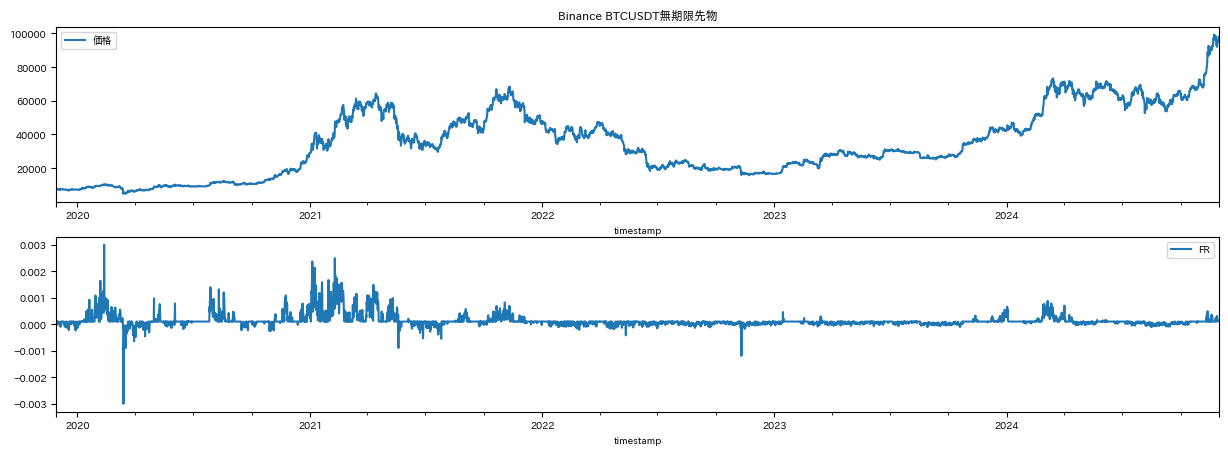

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
ohlcv['binance_perp_open'].plot(label='価格')
plt.title('Binance BTCUSDT無期限先物')
plt.legend()
plt.subplot(2, 1, 2)
ohlcv['fr'].plot(label='FR')
plt.legend();

- コロナショック時に大きくマイナス。
- 2021年のATH相場（特に前半）では大きく加熱。
- 2022年の下落相場では、マイナス。
- 2024年2月～3月も過熱気味。現在はまだまだ。

- ちなみに8時間で0.001（=0.1%）ということは年利換算すると109.5%。

## リターンとのラグ相関

- 8時間リターンと、その終了時点のファンディングレート（ラグ0）

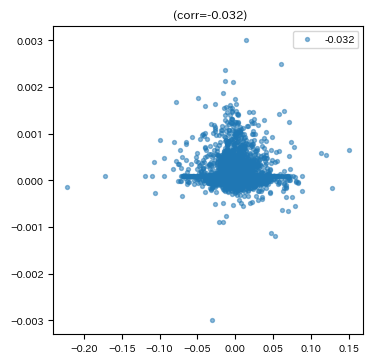

In [26]:
plot_corr(ohlcv['binance_perp_ror'], ohlcv['fr']);

- 8時間リターンと、その終了時点のファンディングレート変化（ラグ0）

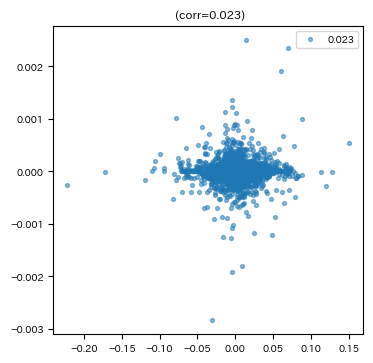

In [27]:
plot_corr(ohlcv['binance_perp_ror'], ohlcv['fr'].diff());

- 8時間リターンと、その終了時点のファンディングレート変化（ラグ1）
- 順相関が見られる。

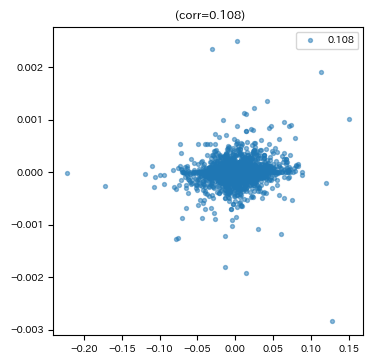

In [28]:
plot_corr(ohlcv['binance_perp_ror'].shift(1), ohlcv['fr'].diff());

- 逆では？
- 1期前のファンディングレート変化が、次の価格リターンに及ぼす影響
- 若干、逆相関が見られる。つまり、基本的にはファンディングレートの変化は、逆張り指標である。

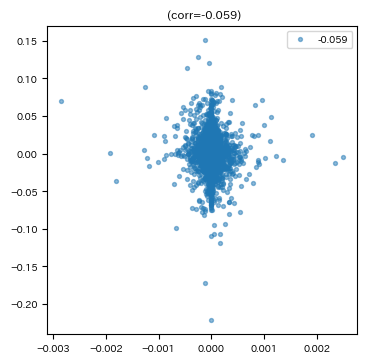

In [29]:
plot_corr(ohlcv['fr'].diff().shift(1), ohlcv['binance_perp_ror']);

# 損益曲線の確認

## 戦略1 ファンディングレートの符号に応じて逆張りロング or ショート

- ファンディングレートがプラスなら、ショート。
- ファンディングレートがマイナスなら、ロング。

- これだけでは使えない。

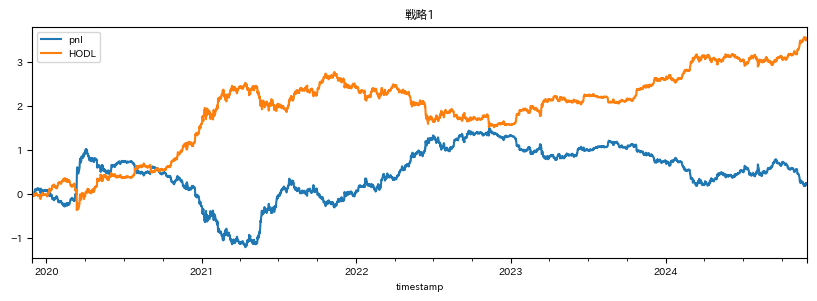

In [31]:
plt.figure(figsize=(10, 3))
plt.title('戦略1')
strategy1 = ohlcv.copy()
strategy1['signal'] = -np.sign(strategy1['fr'].shift(1))
strategy1['pnl'] = strategy1['signal'] * strategy1['binance_perp_ror']
strategy1['pnl'].cumsum().plot()
strategy1['binance_perp_ror'].cumsum().plot(label='HODL')
plt.legend();

## 戦略2 ファンディングレート変化の符号に応じてロング or ショート

- ファンディングレートの変化がプラスなら、ショート。
- ファンディングレートの変化がマイナスなら、ロング。

- 多少改善が見られる。

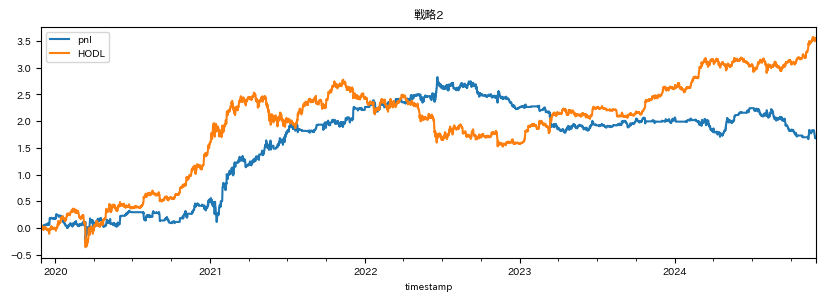

In [32]:
plt.figure(figsize=(10, 3))
plt.title('戦略2')
strategy2 = ohlcv.copy()
strategy2['signal'] = -np.sign(strategy2['fr'].shift(1).diff())
strategy2['pnl'] = strategy2['signal'] * strategy2['binance_perp_ror']
strategy2['pnl'].cumsum().plot()
strategy2['binance_perp_ror'].cumsum().plot(label='HODL')
plt.legend();

## 戦略3 ファンディングレートが0.0001より大きいならショート、小さいならロング

- ファンディングレート > 0.0001でショート。
- ファンディングレート < 0.0001でロング。
- ファンディングレート == 0.0001でノーポジ。

- 一応、HODLをアウトパフォームしている（ただし、コスト考慮なし）

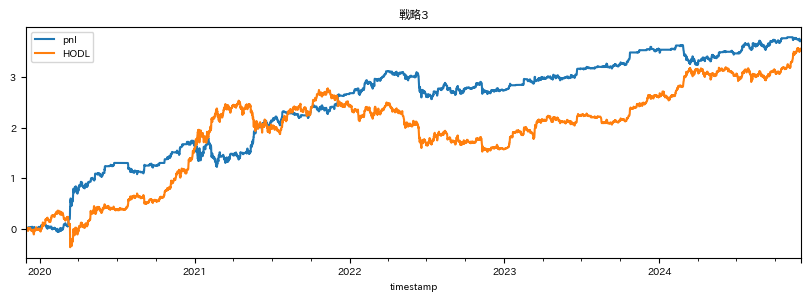

In [33]:
plt.figure(figsize=(10, 3))
plt.title('戦略3')
strategy3 = ohlcv.copy()
strategy3['signal'] = -np.sign((strategy3['fr']-0.0001).shift(1))
strategy3['pnl'] = strategy3['signal'] * strategy3['binance_perp_ror']
strategy3['pnl'].cumsum().plot()
strategy3['binance_perp_ror'].cumsum().plot(label='HODL')
plt.legend();

### 時間帯別(9:00～17:00、17:00～翌1:00、1:00～9:00)の収益性を比較してみる

- 9:00～17:00が指標の効きが弱い感じがする。

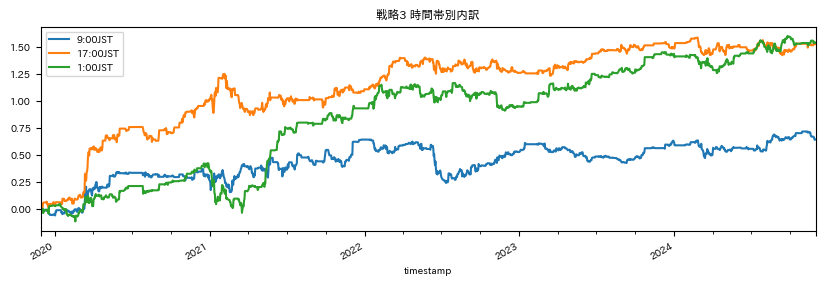

In [34]:
plt.figure(figsize=(10, 3))
plt.title('戦略3 時間帯別内訳')
strategy3['hour'] = strategy1.index.hour
strategy3[strategy3['hour'] == 0]['pnl'].cumsum().plot(label='9:00JST')
strategy3[strategy3['hour'] == 8]['pnl'].cumsum().plot(label='17:00JST')
strategy3[strategy3['hour'] == 16]['pnl'].cumsum().plot(label='1:00JST')
plt.legend();

- PNLの分布を検定してみる。
- 以前登場したMWM検定。

In [35]:
from scipy.stats import mannwhitneyu

- 9～17時と、17時～翌1時　→　有意差あり

In [36]:
tmp = strategy3.dropna()
u_stat, p_value = mannwhitneyu(tmp[tmp['hour'] == 0]['pnl'], tmp[tmp['hour'] == 8]['pnl'], alternative='two-sided')

print(f'U統計量: {u_stat}')
print(f'p値: {p_value:.4f}')

U統計量: 1600712.0
p値: 0.0286


- 9～17時と、翌1時～9時　→　有意差なし

In [37]:
tmp = strategy3.dropna()
u_stat, p_value = mannwhitneyu(tmp[tmp['hour'] == 0]['pnl'], tmp[tmp['hour'] == 16]['pnl'], alternative='two-sided')

print(f'U統計量: {u_stat}')
print(f'p値: {p_value:.4f}')

U統計量: 1612837.0
p値: 0.0781


- 実はHODLの場合も同じ。
- そもそも、ここ数年間は恒常的に日本時間9:00～17:00はビットコインのリターンは悪かった。
- 指標の効きが悪いのは、この時間帯の参加者が少なかったり、値幅が悪かったりするからかも。

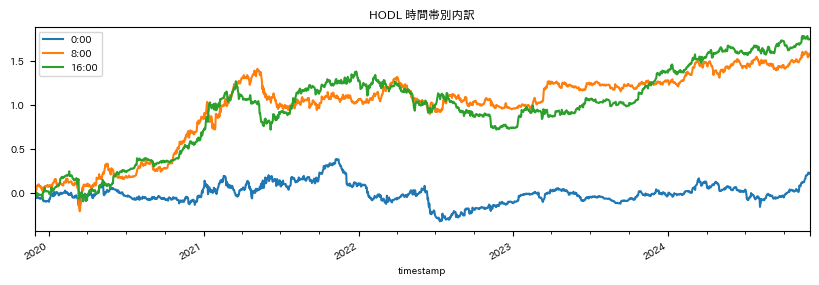

In [38]:
plt.figure(figsize=(10, 3))
plt.title('HODL 時間帯別内訳')
strategy3['hour'] = strategy1.index.hour
strategy3[strategy3['hour'] == 0]['binance_perp_ror'].cumsum().plot(label='0:00')
strategy3[strategy3['hour'] == 8]['binance_perp_ror'].cumsum().plot(label='8:00')
strategy3[strategy3['hour'] == 16]['binance_perp_ror'].cumsum().plot(label='16:00')
plt.legend();

- 9～17時の成績が悪い要因を調べてみる

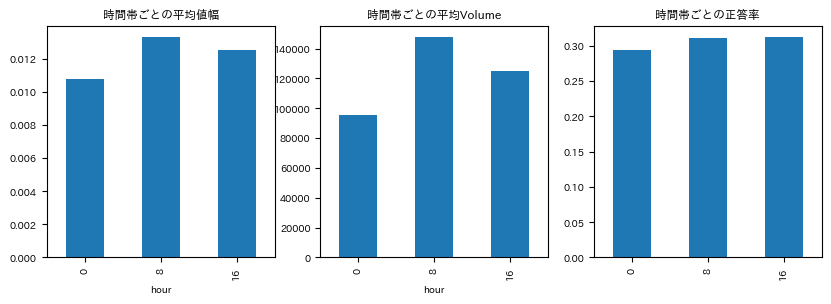

In [39]:
strategy3['ror_abs'] = np.abs(strategy3['binance_perp_ror'])

accuracy = {}
for hour in [0, 8, 16]:
    total = len(strategy3[strategy3['hour'] == hour])
    correct = len(strategy3[(strategy3['hour'] == hour) & (np.sign(strategy3['binance_perp_ror']) == strategy3['signal'])])
    accuracy[hour] = correct / total

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
strategy3.groupby('hour')['ror_abs'].mean().plot(kind='bar', title='時間帯ごとの平均値幅')
plt.subplot(1, 3, 2)
strategy3.groupby('hour')['binance_perp_volume'].mean().plot(kind='bar', title='時間帯ごとの平均Volume');
plt.subplot(1, 3, 3)
pd.Series(accuracy).plot(kind='bar', title='時間帯ごとの正答率');


- 値幅も少ないし、正答率も低い。

### ポジション別(ロング、ショート)の収益性を比較してみる

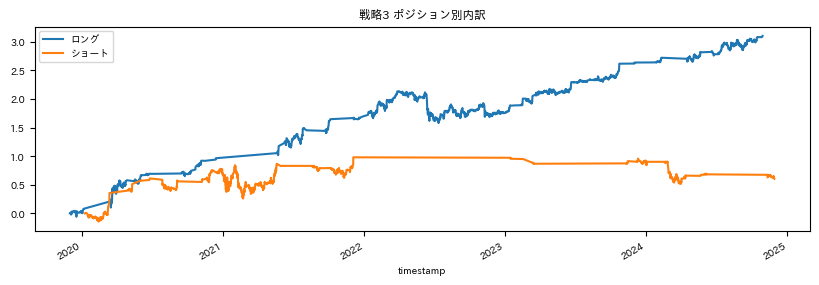

In [41]:
plt.figure(figsize=(10, 3))
plt.title('戦略3 ポジション別内訳')
strategy3[strategy3['signal'] == 1]['pnl'].cumsum().plot(label='ロング')
strategy3[strategy3['signal'] == -1]['pnl'].cumsum().plot(label='ショート')
plt.legend();

- 実は、収益の内訳のほとんどはロングから得られるものであった。

- つまり、
  - 「ファンディングレートが0.0001未満となったときにロング」から得られる収益。
  - 「ファンディングレートが0.0001以上になったときショート」（主に2021年前半や2024年2～3月）は損失を出すことが多かった。つまりショートが踏み上げられる。
  - これは「落ちるときはすとんと落ちて反発しやすい」「バブル相場での上昇トレンドが継続する」といった、ビットコインの定性的な側面が反映されている可能性がある
  - が、普通にこの期間中に上昇局面が多く含まれているから、の可能性もある。

## 知見

- 指標はいろいろな切り口によって細分化すると、特徴が見えることがある。
- 戦略は、ロング側とショート側の収益構造を必ず確認すること。

# まとめ

- ファンディングレートは、市況の過熱度合いを表し、指標となりうる。
- 短期の値動き指標としては逆張りの指標。
- 特に、ファンディングレートがマイナスになったときに反発しやすい傾向を表している。ただしLUNAやFTXなどの強ファンダがあるときは要注意。
- 追加の検証アイデア
  - 8時間の中でのファンディングレートの変化と価格変動の関係は？（途中のファンディングレートは自炊可能）
  - 他のアルトコインでは？
  - ファンディング時刻をまたぐときの値動きは？
